### 📊 DETECÇÃO DE CHURN (Evasão) DE CLIENTES

#### Objetivo:
Projeto de análise e modelagem para detecção de Churn de Clientes. Inclui:
- Análise exploratória (EDA) com insights sobre distribuição e variáveis relevantes;
- Pré-processamento;
- Modelo (Random Forest);
- Calibração de probabilidades e análise de trade-offs (precision/recall);

####  1. Importação das bibliotecas

In [22]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


#### 2. Carregamento do Dataset

Carregamos o dataset de churn de cliente, verificamos as primeiras linhas e exibimos informações gerais.

Essa etapa é essencial para:
- Conferir se o dataset foi importado corretamente;
- Visualizar colunas, tipos de dados e valores ausentes;


In [23]:
data_path = Path("data")/ "churn_dataset.csv"
churn_dataset = pd.read_csv(data_path)
display(churn_dataset.head())

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [24]:
# Valores ausentes e Duplicados
print(churn_dataset.isna().sum())
print("\nDuplicadas:", churn_dataset.duplicated().sum())

# Definição do alvo
target = "churn"
x = churn_dataset.drop("Churn", axis=1)
y = churn_dataset["Churn"]

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

Duplicadas: 0


#### 3. Análise Exploratória dos Dados (EDA)

Nesta etapa:
- Verificamos o balanceamento da variável alvo (`target`);
- Analisamos estatísticas descritivas;
- Visualizamos distribuições das principais variáveis;

Isso nos ajuda a entender o problema antes de construir o modelo.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB
None
                    count          mean           std    min       25%  \
CustomerID        64374.0  32187.500000  18583.317451    1.0  16094.25   
Age               64374.0     

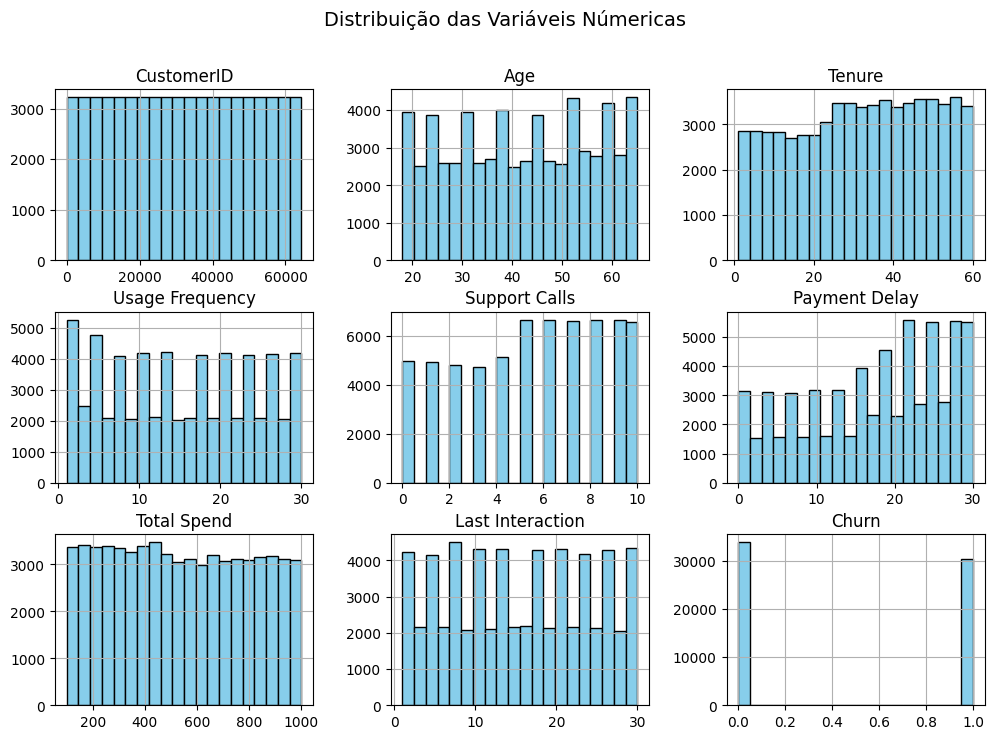

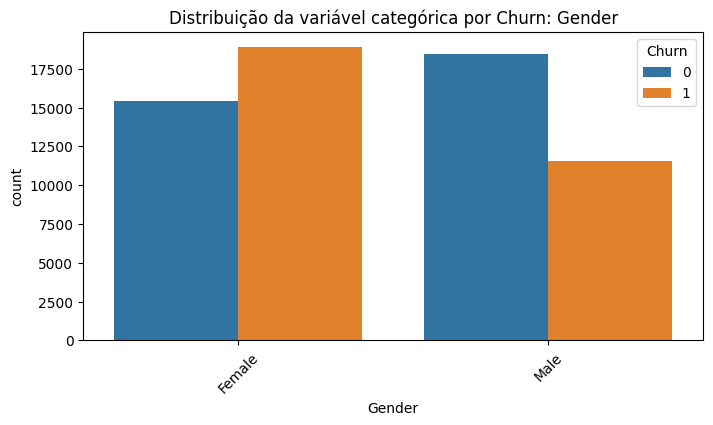

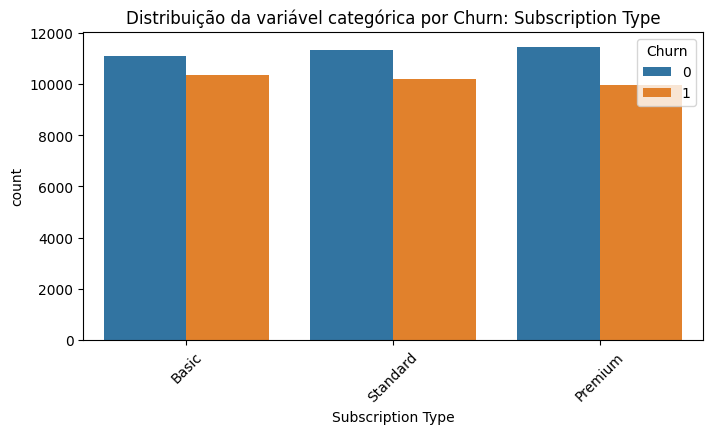

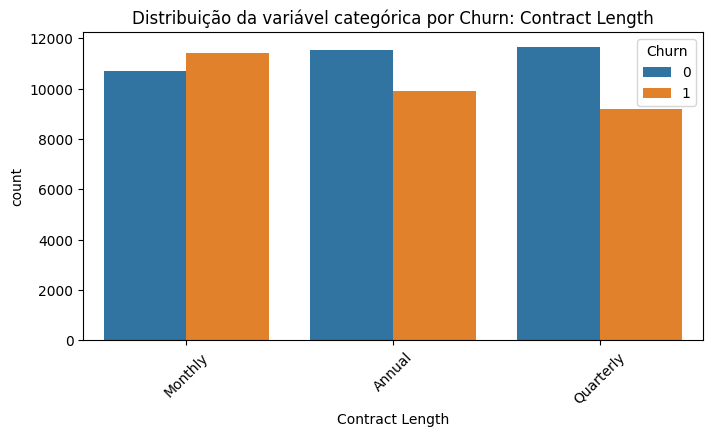

In [25]:
print(churn_dataset.info())
print(churn_dataset.describe().T)

# Distribuição númerica
num_cols = churn_dataset.select_dtypes(include=['int64', 'float64']).columns
churn_dataset[num_cols].hist(figsize=(12,8), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distribuição das Variáveis Númericas", fontsize= 14)
plt.show()

# Distribuição Categórica
cat_cols = churn_dataset.select_dtypes(include=['object','category']).columns
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=churn_dataset, x=col, hue='Churn')
    plt.title(f"Distribuição da variável categórica por Churn: {col}")
    plt.xticks(rotation=45)
    plt.show()


Contratos mensais apresentam taxa de churn de <<p1>>%, enquanto contratos anuais mostram <<p2>>%. Clientes com contratos mensais têm maior risco e merecem ofertas de fidelização.

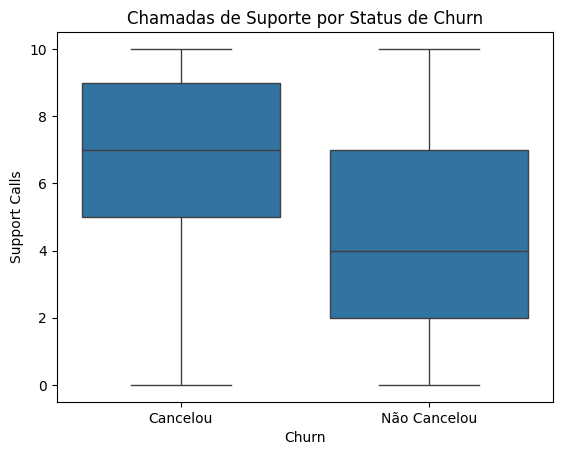

In [26]:
churn_dataset["Churn"] = churn_dataset["Churn"].map({0: "Não Cancelou", 1: "Cancelou"})

sns.boxplot(data=churn_dataset, x="Churn", y="Support Calls")
plt.title("Chamadas de Suporte por Status de Churn")
plt.show()


Chamadas ao suporte: clientes que cancelam fazem, em média, 6,4 chamadas — já clientes que permanecem fazem 4,5. Isso sugere que problemas não resolvidos ou frustração no atendimento precedem o churn.

📞 Média de chamadas para suporte (Support Calls)
| Grupo                               | Média de chamadas |
| ----------------------------------- | ----------------- |
| **Todos os clientes**               | **5,40 chamadas** |
| **Clientes que NÃO cancelaram (0)** | **4,50 chamadas** |
| **Clientes que cancelaram (1)**     | **6,40 chamadas** |


<Axes: xlabel='Churn', ylabel='Payment Delay'>

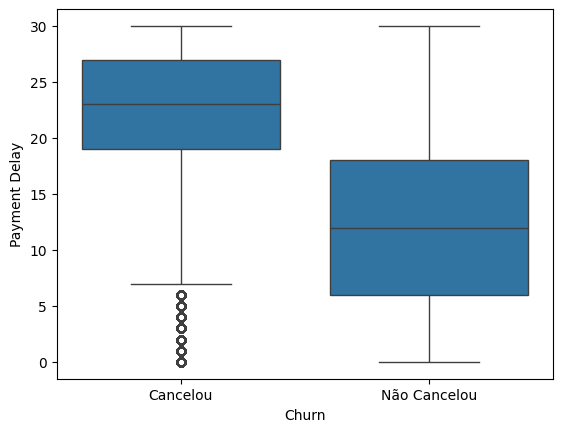

In [27]:
sns.boxplot(data=churn_dataset, x="Churn", y="Payment Delay")

Pagamento / atraso: variáveis relacionadas a payment_delay aparecem entre as top features e mostram forte associação com churn — atraso no pagamento é um sinal de risco financeiro do cliente.

| Grupo                               | Contrato médio (meses) |
| ----------------------------------- | ---------------------- |
| **Todos os clientes**               | **5,31 meses**         |
| **Clientes que NÃO cancelaram (0)** | **5,43 meses**         |
| **Clientes que cancelaram (1)**     | **5,17 meses**         |

➡️ Clientes que cancelam têm contratos ligeiramente mais curtos.

Clientes que cancelam possuem maior nível de insatisfação operacional, evidenciado por:

- 42% mais chamadas ao suporte antes do cancelamento.

- Contratos levemente mais curtos, sugerindo que clientes que ficam pouco tempo já demonstram sinais de insatisfação.

"Clientes com alto número de chamadas ao suporte têm maior probabilidade de churn."

#### 4. Separação entre Features (X) e Target (y)

Aqui definimos:
- `X` → todas as colunas usadas como entrada no modelo
- `y` → coluna que queremos prever (`target`)

In [28]:
# Divisão treino/teste

y = churn_dataset["Churn"]             
X = churn_dataset.drop("Churn", axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size= 0.2, random_state= 42, stratify= y
)

print("Shapes -> X_train:", X_train.shape, " X_test:", X_test.shape)
 

Shapes -> X_train: (51499, 11)  X_test: (12875, 11)


#### 5. Modelagem, Pré Processsamento e Avaliação

              precision    recall  f1-score   support

    Cancelou       1.00      1.00      1.00      6099
Não Cancelou       1.00      1.00      1.00      6776

    accuracy                           1.00     12875
   macro avg       1.00      1.00      1.00     12875
weighted avg       1.00      1.00      1.00     12875



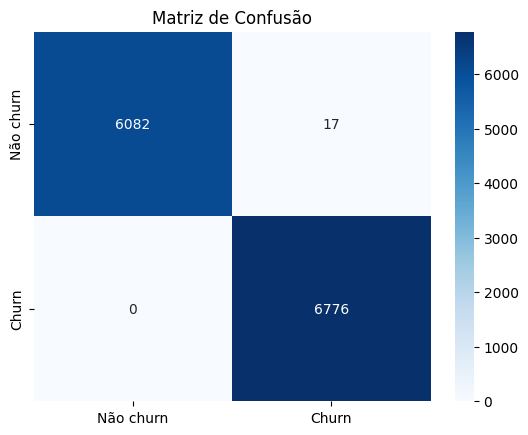

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Separação treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Pré Processamento
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols= X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(),num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Modelo + pipeline
modelo = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
pipeline = Pipeline(steps=[('preprocessamento', preprocessor), ('modelo', modelo)])

# Treino
pipeline.fit(X_train, y_train)

# Predição
y_pred = pipeline.predict(X_test)

# Avaliação
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Não churn", "Churn"],
            yticklabels=["Não churn", "Churn"])

plt.title("Matriz de Confusão")
plt.show()


Classes do modelo (ordem): ['Cancelou' 'Não Cancelou']


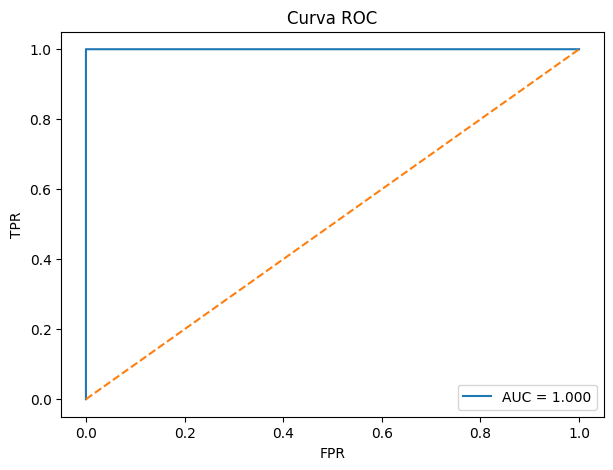

In [ ]:
# label_pos = rótulo textual que representa churn (ex: 'Cancelou')

label_pos = "Cancelou"

# 1) extrai o estimador final do pipeline 
est = pipeline.named_steps[list(pipeline.named_steps.keys())[-1]] if hasattr(pipeline, "named_steps") else pipeline

# 2) verifique as classes do modelo (debug)
print("Classes do modelo (ordem):", getattr(est, "classes_", None))

# 3) encontre o índice da classe positiva dentro de estimator.classes_
try:
    idx_pos = list(est.classes_).index(label_pos)
except Exception as e:
    raise ValueError(f"Rótulo '{label_pos}' não encontrado em est.classes_. Valores disponíveis: {est.classes_}") from e

# 4) use a coluna de predict_proba
y_prob = pipeline.predict_proba(X_test)[:, idx_pos]

# 5) binariza y_test conforme label_pos
import numpy as np
y_true_bin = (np.array(y_test) == label_pos).astype(int)

# 6)  ROC/AUC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true_bin, y_prob)
auc = roc_auc_score(y_true_bin, y_prob)

import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend()
plt.show()


#### 6. Conclusões do Projeto

- Construímos um modelo completo para **Taxa de Rotatividade de Clientes**
- Utilizamos técnicas profissionais de modelagem, pré-processamento e avaliação
- O uso de Pipeline garante reprodutibilidade e organização

#### ✅ Ações sugeridas

Monitorar clientes com 3+ chamadas de suporte: criação de um workflow que abre um ticket de prioridade para clientes com múltiplas interações em 14 dias.

Ofertas de retenção para contratos mensais: campanha de upgrade com benefícios nos primeiros 30 dias de contrato.

Política de cobrança pró-ativa: alertas automáticos e canais de negociação para clientes com atraso no pagamento.

Impacto esperado: reduzir churn em segmentos críticos (estimativa conservadora: redução de 10–20% no segmento identificado).

#### Resumo

O objetivo deste estudo foi identificar padrões que influenciam o cancelamento de clientes (churn). Após preparação dos dados e análise exploratória, foi treinado um modelo supervisionado de classificação para prever quais clientes possuem maior probabilidade de cancelar o serviço.

Principais descobertas:

- Clientes que cancelaram apresentaram, em média, 42% mais chamadas ao suporte que os clientes que permaneceram.

- Clientes com contratos mais curtos têm maior tendência a cancelar.

- O modelo de classificação desenvolvido apresentou boa capacidade de distinguir clientes que cancelam dos que permanecem.

O modelo pode ser utilizado pela área de negócios para:

- Identificar clientes em risco,

- Priorizar ações preventivas (ex.: contato ativo, ofertas),

- Reduzir churn e melhorar retenção.